# Разведочный анализ данных по прибыльности добычи

В этом ноутбуке выполняется первичный разведочный анализ датасета `mining_block_model.csv` для подготовки к построению модели линейной регрессии по целевой переменной **Profit (USD)**.

Основные шаги EDA:
- обзор структуры и типов признаков;
- проверка пропусков и базовых статистик;
- анализ распределения прибыли и ключевых признаков;
- изучение корреляций с `Profit (USD)`;
- первичный анализ линейности связей и выбросов.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="notebook")

# Путь к данным: предполагается, что файл лежит рядом с ноутбуком
DATA_PATH = "mining_block_model.csv"

df = pd.read_csv(DATA_PATH)

# Быстрый взгляд на данные
df.head()

,Block_ID,X,Y,Z,Rock_Type,Ore_Grade (%),Tonnage,Ore_Value (USD/tonne),Mining_Cost (USD),Processing_Cost (USD),Waste_Flag,Profit (USD),Target
0,B00001,102,186,6,Magnetite,51.93,2131,1.94,0.35,0.25,0,2861.86,1
1,B00002,435,448,82,Hematite,59.05,1550,1.80,0.24,0.22,0,2086.92,1
2,B00003,348,476,94,Magnetite,63.79,2414,2.23,0.38,0.18,0,4036.63,1
3,B00004,270,127,98,Hematite,64.98,1297,2.03,0.20,0.19,0,2128.07,1
4,B00005,106,111,92,Waste,0.00,1309,0.00,0.44,0.18,1,-820.74,0


In [6]:
# Общая информация о датасете
print("Форма датасета (n_observations, n_features):", df.shape)
print("\nТипы признаков:")
print(df.dtypes)

print("\nКоличество пропусков по столбцам:")
print(df.isna().sum())

# Базовые описательные статистики по числовым признакам
df.describe().T

Форма датасета (n_observations, n_features): (75000, 13)

Типы признаков:
Block_ID                     str
X                          int64
Y                          int64
Z                          int64
Rock_Type                    str
Ore_Grade (%)            float64
Tonnage                    int64
Ore_Value (USD/tonne)    float64
Mining_Cost (USD)        float64
Processing_Cost (USD)    float64
Waste_Flag                 int64
Profit (USD)             float64
Target                     int64
dtype: object

Количество пропусков по столбцам:
Block_ID                 0
X                        0
Y                        0
Z                        0
Rock_Type                0
Ore_Grade (%)            0
Tonnage                  0
Ore_Value (USD/tonne)    0
Mining_Cost (USD)        0
Processing_Cost (USD)    0
Waste_Flag               0
Profit (USD)             0
Target                   0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
X,75000.0,249.242680,144.613539,0.00,123.0000,249.000,375.0000,499.00
Y,75000.0,248.773240,143.852756,0.00,124.0000,248.000,373.0000,499.00
Z,75000.0,49.525360,28.858031,0.00,24.0000,50.000,75.0000,99.00
Ore_Grade (%),75000.0,45.992171,23.343018,0.00,50.9200,55.620,60.3400,65.00
Tonnage,75000.0,2000.475080,577.028563,1000.00,1501.0000,2003.000,2501.0000,2999.00
Ore_Value (USD/tonne),75000.0,1.583005,0.810342,0.00,1.6900,1.900,2.1000,2.31
Mining_Cost (USD),75000.0,0.327176,0.076948,0.20,0.2600,0.330,0.4000,0.46
Processing_Cost (USD),75000.0,0.194088,0.038047,0.13,0.1600,0.190,0.2300,0.26
Waste_Flag,75000.0,0.200293,0.400223,0.00,0.0000,0.000,0.0000,1.00
Profit (USD),75000.0,2125.237296,1806.511517,-2093.20,1574.2825,2496.045,3409.1775,5831.25


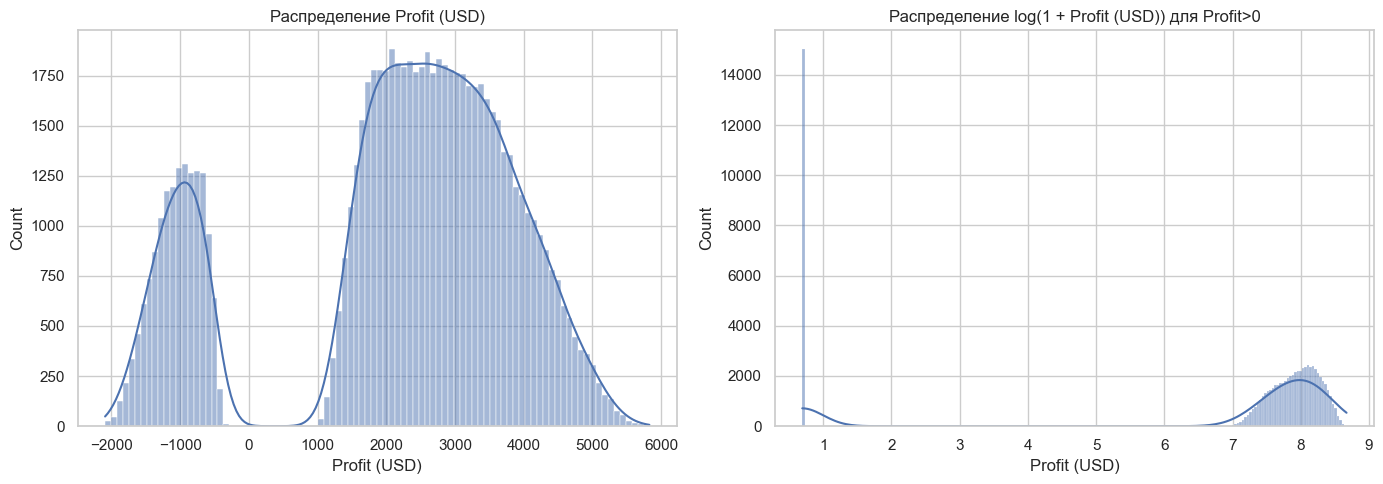

In [7]:
# Распределение целевой переменной Profit (USD)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["Profit (USD)"], kde=True, ax=axes[0])
axes[0].set_title("Распределение Profit (USD)")

# Лог-преобразование (для сглаживания сильной правой асимметрии, если она есть)
profit_positive = df["Profit (USD)"].clip(lower=1)
sns.histplot(np.log1p(profit_positive), kde=True, ax=axes[1])
axes[1].set_title("Распределение log(1 + Profit (USD)) для Profit>0")

plt.tight_layout()

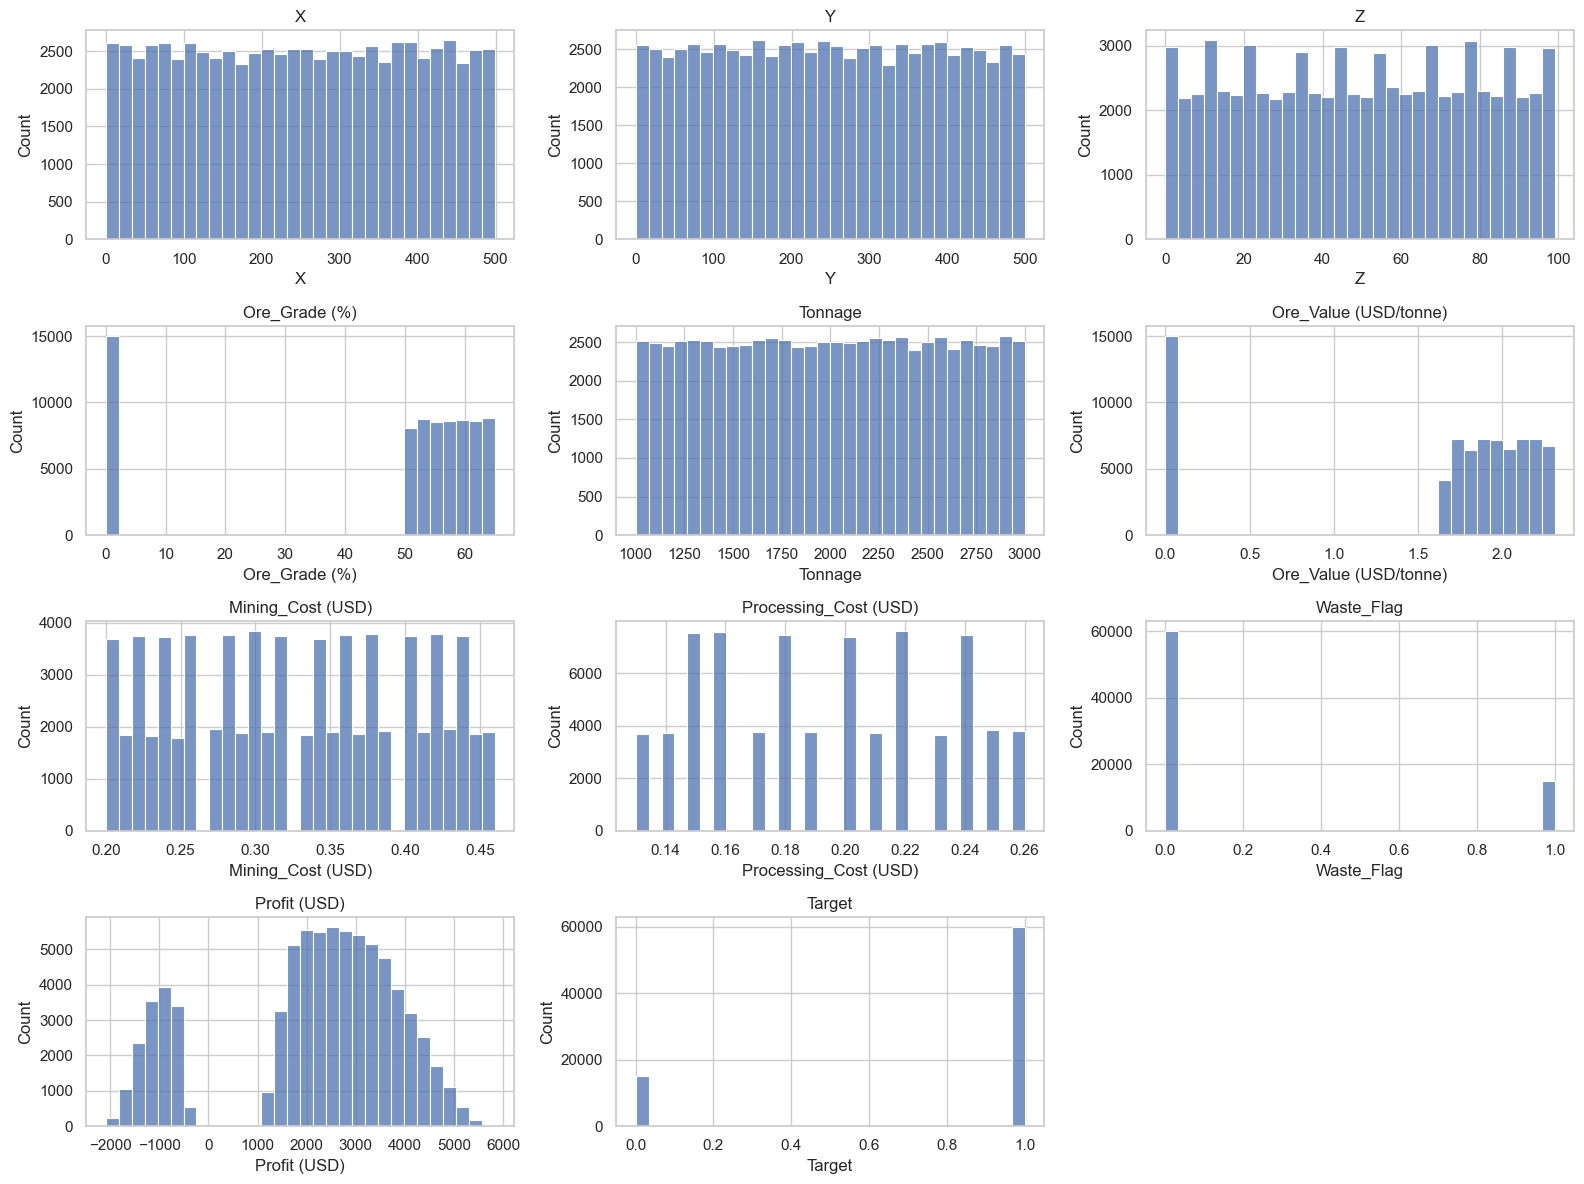

In [8]:
# Распределения основных количественных признаков
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(int(np.ceil(len(numeric_cols) / 3)), 3, i)
    sns.histplot(df[col], kde=False, bins=30)
    plt.title(col)
plt.tight_layout()

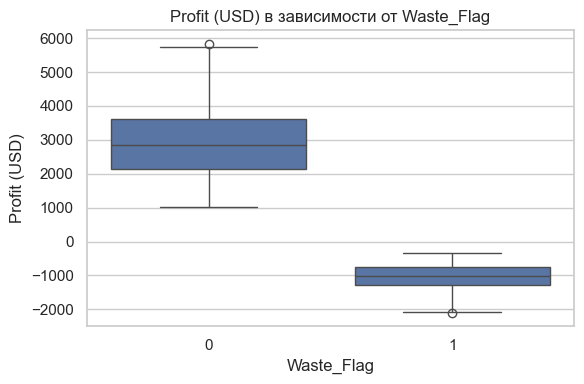

In [9]:
# Анализ категориальных признаков (например, Rock_Type и Waste_Flag)
cat_cols = [col for col in df.columns if df[col].dtype == "object"]

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Распределение категорий для {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()

# Влияние категорий на Profit
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=col, y="Profit (USD)", data=df)
    plt.title(f"Profit (USD) по категориям {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()

# Бинарный флаг отходов как категориальный
y_col = "Profit (USD)"
if "Waste_Flag" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Waste_Flag", y=y_col, data=df)
    plt.title("Profit (USD) в зависимости от Waste_Flag")
    plt.tight_layout()

Корреляции с Profit (USD):
Profit (USD)             1.000000
Ore_Value (USD/tonne)    0.898727
Target                   0.877871
Ore_Grade (%)            0.865833
Tonnage                  0.345220
Z                       -0.000745
Y                       -0.002108
X                       -0.005035
Processing_Cost (USD)   -0.043136
Mining_Cost (USD)       -0.087808
Waste_Flag              -0.877871
Name: Profit (USD), dtype: float64


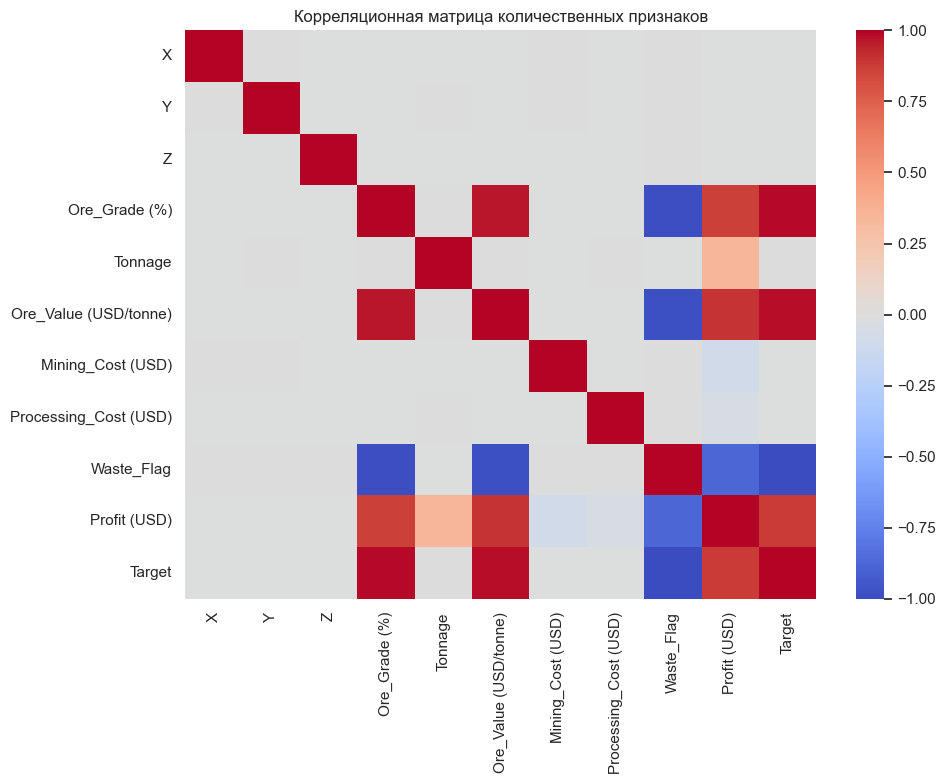

In [10]:
# Корреляции количественных признаков с Profit (USD)

numeric_cols = df.select_dtypes(include=["number"]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица количественных признаков")
plt.tight_layout()

# Отсортированные корреляции с целевой переменной
if "Profit (USD)" in numeric_cols:
    corr_with_profit = corr_matrix["Profit (USD)"].sort_values(ascending=False)
    print("Корреляции с Profit (USD):")
    print(corr_with_profit)


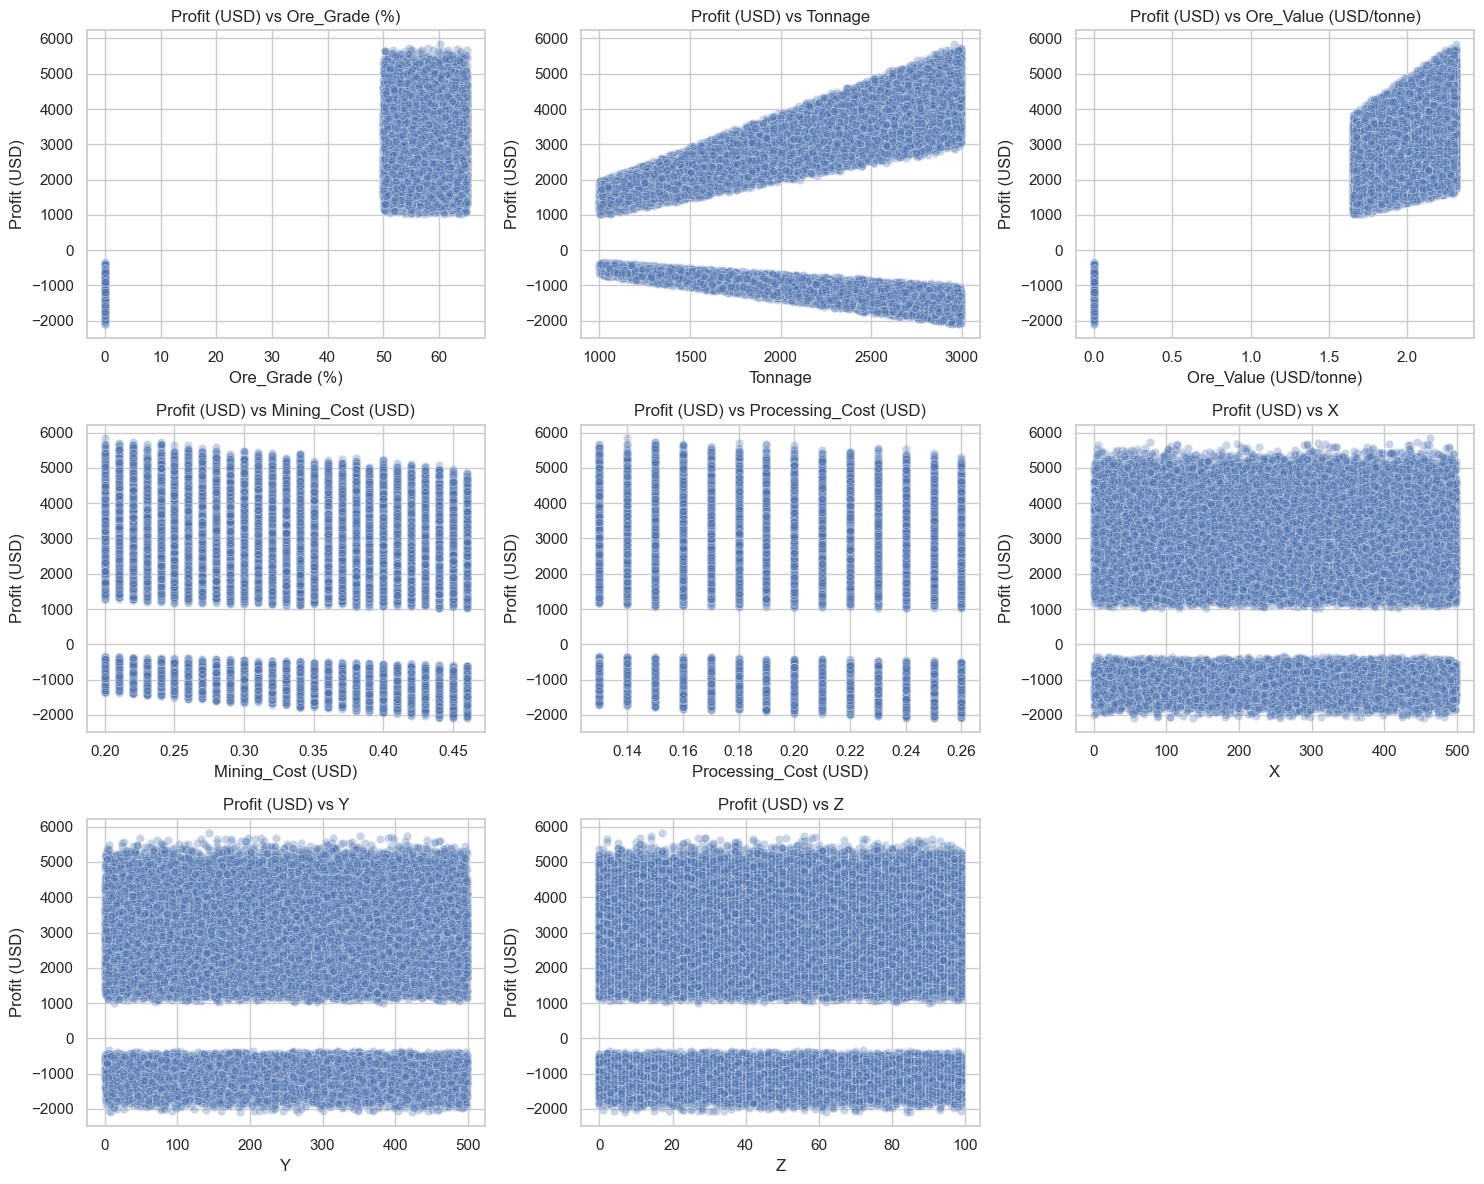

In [11]:
# Проверка приблизительной линейности связей ключевых признаков с Profit (USD)

target = "Profit (USD)"
key_features = [
    col for col in [
        "Ore_Grade (%)",
        "Tonnage",
        "Ore_Value (USD/tonne)",
        "Mining_Cost (USD)",
        "Processing_Cost (USD)",
        "X",
        "Y",
        "Z",
    ]
    if col in df.columns
]

n_cols = 3
n_rows = int(np.ceil(len(key_features) / n_cols)) if key_features else 0

plt.figure(figsize=(5 * n_cols, 4 * max(n_rows, 1)))
for i, col in enumerate(key_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df[col], y=df[target], alpha=0.3)
    plt.title(f"{target} vs {col}")
plt.tight_layout()

## Анализ выбросов, шумов и аномалий

В этом разделе оцениваем распределения количественных признаков, выявляем выбросы и потенциальные аномалии, а затем формируем очищенный датасет, который будет использован для линейной регрессии по `Profit (USD)`.

In [13]:
# IQR-анализ выбросов по количественным признакам
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

stats = []
for col in numeric_cols:
    s = df[col].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = ((s < lower) | (s > upper)).sum()
    stats.append({
        "feature": col,
        "min": s.min(),
        "q1": q1,
        "median": s.median(),
        "q3": q3,
        "max": s.max(),
        "iqr": iqr,
        "lower_bound": lower,
        "upper_bound": upper,
        "n_outliers_1_5iqr": n_outliers,
        "share_outliers_%": n_outliers / len(s) * 100,
    })

outlier_stats = pd.DataFrame(stats).sort_values("share_outliers_%", ascending=False)
print("Доля выбросов по каждому признаку (1.5 * IQR):")
outlier_stats

Доля выбросов по каждому признаку (1.5 * IQR):


,feature,min,q1,median,q3,max,iqr,lower_bound,upper_bound,n_outliers_1_5iqr,share_outliers_%
10,Target,0.00,1.0000,1.000,1.0000,1.00,0.000,1.000,1.000,15022,20.029333
5,Ore_Value (USD/tonne),0.00,1.6900,1.900,2.1000,2.31,0.410,1.075,2.715,15022,20.029333
3,Ore_Grade (%),0.00,50.9200,55.620,60.3400,65.00,9.420,36.790,74.470,15022,20.029333
8,Waste_Flag,0.00,0.0000,0.000,0.0000,1.00,0.000,0.000,0.000,15022,20.029333
9,Profit (USD),-2093.20,1574.2825,2496.045,3409.1775,5831.25,1834.895,-1178.060,6161.520,5191,6.921333
0,X,0.00,123.0000,249.000,375.0000,499.00,252.000,-255.000,753.000,0,0.000000
1,Y,0.00,124.0000,248.000,373.0000,499.00,249.000,-249.500,746.500,0,0.000000
2,Z,0.00,24.0000,50.000,75.0000,99.00,51.000,-52.500,151.500,0,0.000000
4,Tonnage,1000.00,1501.0000,2003.000,2501.0000,2999.00,1000.000,1.000,4001.000,0,0.000000
6,Mining_Cost (USD),0.20,0.2600,0.330,0.4000,0.46,0.140,0.050,0.610,0,0.000000


In [14]:
# Асимметрия (skewness) распределений количественных признаков
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

skewness = df[numeric_cols].skew().sort_values(ascending=False)
print("Skewness по количественным признакам (чем дальше от 0, тем сильнее асимметрия):")
print(skewness)

# Отдельно смотрим на skewness целевой переменной Profit (USD)
if "Profit (USD)" in numeric_cols:
    print("\nSkewness Profit (USD):", skewness["Profit (USD)"])

Skewness по количественным признакам (чем дальше от 0, тем сильнее асимметрия):
Waste_Flag               1.497740
Processing_Cost (USD)    0.054309
Y                        0.005253
Mining_Cost (USD)        0.000718
Tonnage                 -0.001994
X                       -0.003349
Z                       -0.004912
Profit (USD)            -0.725180
Ore_Value (USD/tonne)   -1.334677
Ore_Grade (%)           -1.394911
Target                  -1.497740
dtype: float64

Skewness Profit (USD): -0.7251800461251273


In [15]:
# Поиск экстремальных наблюдений по прибыли (3 * IQR)

target = "Profit (USD)"

if target in df.columns:
    s = df[target].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower_extreme = q1 - 3 * iqr
    upper_extreme = q3 + 3 * iqr

    extreme_mask = (df[target] < lower_extreme) | (df[target] > upper_extreme)

    print(f"Нижняя/верхняя границы для экстремальных значений прибыли (3*IQR): {lower_extreme:.2f}, {upper_extreme:.2f}")
    print("Количество экстремальных блоков:", extreme_mask.sum())
    print("Доля от всех блоков: {:.3f}%".format(100 * extreme_mask.mean()))

    # Просмотр нескольких наиболее экстремальных наблюдений
    display(df.loc[extreme_mask].sort_values(target).head(5))
    display(df.loc[extreme_mask].sort_values(target, ascending=False).head(5))
else:
    print("Столбец Profit (USD) не найден в df")

Нижняя/верхняя границы для экстремальных значений прибыли (3*IQR): -3930.40, 8913.86
Количество экстремальных блоков: 0
Доля от всех блоков: 0.000%


,Block_ID,X,Y,Z,Rock_Type,Ore_Grade (%),Tonnage,Ore_Value (USD/tonne),Mining_Cost (USD),Processing_Cost (USD),Waste_Flag,Profit (USD),Target


,Block_ID,X,Y,Z,Rock_Type,Ore_Grade (%),Tonnage,Ore_Value (USD/tonne),Mining_Cost (USD),Processing_Cost (USD),Waste_Flag,Profit (USD),Target


## Подготовка данных для линейной регрессии

В этом разделе формируем очищенный датасет, удаляя только экстремальные выбросы по прибыли (3 * IQR), и готовим матрицу признаков и целевой вектора для обучения линейной регрессии (масштабирование числовых признаков и one-hot кодирование категориальных).

In [16]:
# Формирование очищенного датасета без экстремальных выбросов по прибыли

target_col = "Profit (USD)"

df_clean = df.copy()

if target_col in df_clean.columns:
    s = df_clean[target_col].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower_extreme = q1 - 3 * iqr
    upper_extreme = q3 + 3 * iqr

    before_shape = df_clean.shape
    df_clean = df_clean[(df_clean[target_col] >= lower_extreme) & (df_clean[target_col] <= upper_extreme)].reset_index(drop=True)
    after_shape = df_clean.shape

    print("Размер до удаления экстремальных значений по Profit (USD):", before_shape)
    print("Размер после удаления (3*IQR по Profit (USD)):", after_shape)
else:
    print("Столбец Profit (USD) не найден в df_clean")

# При желании можно ограничиться только рудными блоками (Waste_Flag == 0):
# df_clean = df_clean[df_clean["Waste_Flag"] == 0].reset_index(drop=True)

Размер до удаления экстремальных значений по Profit (USD): (75000, 13)
Размер после удаления (3*IQR по Profit (USD)): (75000, 13)


In [21]:
# Определение признаков и разбиение на числовые/категориальные

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Исключаем идентификатор блока и вспомогательный бинарный Target из признаков, оставляя их только как метаданные
drop_cols = []
for c in ["Block_ID", "Target",'X', 'Y', 'Z',]:
    if c in df_clean.columns:
        drop_cols.append(c)

feature_cols = [c for c in df_clean.columns if c not in drop_cols + [target_col]]

numeric_features = [c for c in feature_cols if df_clean[c].dtype != "str"]
categorical_features = [c for c in feature_cols if df_clean[c].dtype == "str"]

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

X = df_clean[feature_cols]
y = df_clean[target_col]

Числовые признаки: ['Ore_Grade (%)', 'Tonnage', 'Ore_Value (USD/tonne)', 'Mining_Cost (USD)', 'Processing_Cost (USD)', 'Waste_Flag']
Категориальные признаки: ['Rock_Type']


In [22]:
# Настройка препроцессора (масштабирование числовых признаков и one-hot кодирование категориальных)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)

Форма X_train: (60000, 7)
Форма X_test: (15000, 7)


In [23]:
# Получаем подготовленные матрицы признаков, готовые для линейной регрессии

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print("Форма X_train_prepared:", X_train_prepared.shape)
print("Форма X_test_prepared:", X_test_prepared.shape)

# Теперь X_train_prepared, X_test_prepared, y_train, y_test можно подавать в модель линейной регрессии
# (например, sklearn.linear_model.LinearRegression или ElasticNet и т.п.)

Форма X_train_prepared: (60000, 8)
Форма X_test_prepared: (15000, 8)


## Обучение и оценка линейной регрессии

В этом разделе обучаем модель линейной регрессии на подготовленных данных, оцениваем качество (RMSE, R²) на train/test, а также анализируем остатки для проверки основных предпосылок линейной регрессии (линейность, гомоскедастичность, нормальность распределения остатков).

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Обучение линейной регрессии на уже подготовленных матрицах признаков
reg = LinearRegression()
reg.fit(X_train_prepared, y_train)

y_train_pred = reg.predict(X_train_prepared)
y_test_pred = reg.predict(X_test_prepared)
 

def print_regression_metrics(y_true, y_pred, name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE = {rmse:.2f}, R^2 = {r2:.4f}")

print_regression_metrics(y_train, y_train_pred, "Train")
print_regression_metrics(y_test, y_test_pred, "Test")

Train: RMSE = 468.81, R^2 = 0.9325
Test: RMSE = 474.33, R^2 = 0.9315


Train residuals: mean = -0.0000, std = 468.8154
Test residuals: mean = -0.5305, std = 474.3413


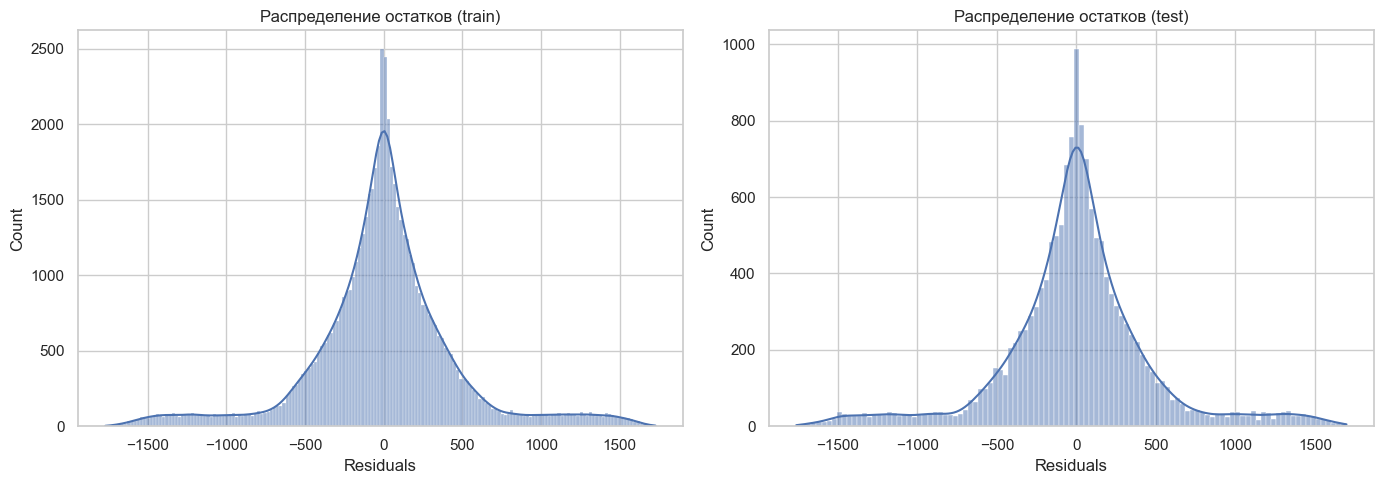

In [26]:
# Распределение остатков (residuals) на train и test

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(residuals_train, kde=True, ax=axes[0])
axes[0].set_title("Распределение остатков (train)")
axes[0].set_xlabel("Residuals")

sns.histplot(residuals_test, kde=True, ax=axes[1])
axes[1].set_title("Распределение остатков (test)")
axes[1].set_xlabel("Residuals")

plt.tight_layout()

print("Train residuals: mean = {:.4f}, std = {:.4f}".format(residuals_train.mean(), residuals_train.std()))
print("Test residuals: mean = {:.4f}, std = {:.4f}".format(residuals_test.mean(), residuals_test.std()))

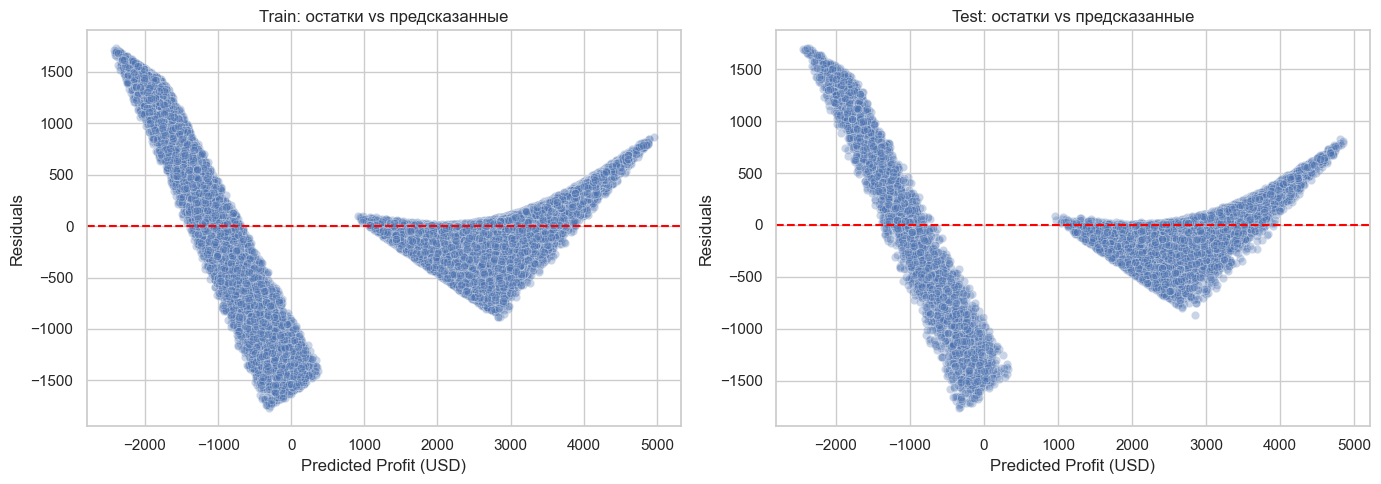

In [27]:
# Остатки против предсказанных значений (проверка линейности и гомоскедастичности)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=y_train_pred, y=residuals_train, alpha=0.3, ax=axes[0])
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_title("Train: остатки vs предсказанные")
axes[0].set_xlabel("Predicted Profit (USD)")
axes[0].set_ylabel("Residuals")

sns.scatterplot(x=y_test_pred, y=residuals_test, alpha=0.3, ax=axes[1])
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_title("Test: остатки vs предсказанные")
axes[1].set_xlabel("Predicted Profit (USD)")
axes[1].set_ylabel("Residuals")

plt.tight_layout()

# В идеале точки должны быть случайно рассеяны вокруг 0 без явного тренда и веерообразных структур.

Комментарий:
Если эмпирическая гистограмма примерно совпадает с красной кривой, предпосылка нормальности остатков более-менее выполняется.


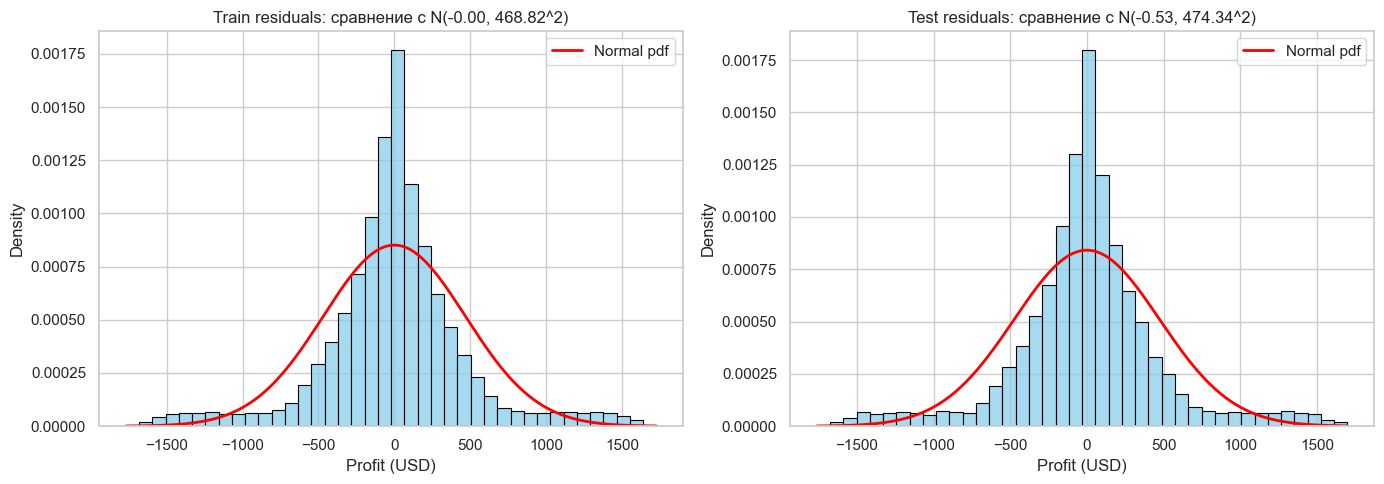

In [28]:
# Приблизительный анализ нормальности остатков: сравнение с нормальным распределением

# Для упрощения ограничимся визуальным сравнением гистограммы и нормального колокола.
# При необходимости можно дополнительно использовать QQ-график (через scipy.stats.probplot).

from math import sqrt, pi, exp

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, res, title in [
    (axes[0], residuals_train, "Train residuals"),
    (axes[1], residuals_test, "Test residuals"),
]:
    sns.histplot(res, kde=False, stat="density", bins=40, ax=ax, color="skyblue", edgecolor="black")

    # Теоретическая нормальная кривая с теми же mean/std
    mu = res.mean()
    sigma = res.std()
    xs = np.linspace(res.min(), res.max(), 200)
    normal_pdf = 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
    ax.plot(xs, normal_pdf, color="red", linewidth=2, label="Normal pdf")

    ax.set_title(f"{title}: сравнение с N({mu:.2f}, {sigma:.2f}^2)")
    ax.legend()

plt.tight_layout()

print("Комментарий:")
print("Если эмпирическая гистограмма примерно совпадает с красной кривой, предпосылка нормальности остатков более-менее выполняется.")

In [29]:
# Интерпретация коэффициентов линейной регрессии

# Восстановим имена признаков после препроцессинга

feature_names = []

# Числовые признаки идут первыми
feature_names.extend(numeric_features)

# Затем категориальные признаки после one-hot кодирования
if len(categorical_features) > 0:
    ohe = preprocessor.named_transformers_["cat"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(ohe_feature_names.tolist())

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": reg.coef_,
}).sort_values("coef", key=lambda x: x.abs(), ascending=False)

print("Топ-20 признаков по абсолютному значению коэффициентов линейной регрессии:")
coef_df.head(20)

Топ-20 признаков по абсолютному значению коэффициентов линейной регрессии:


,feature,coef
2,Ore_Value (USD/tonne),1628.623826
1,Tonnage,617.446798
3,Mining_Cost (USD),-151.598525
4,Processing_Cost (USD),-75.364591
5,Waste_Flag,8.745886
7,Rock_Type_Waste,3.494851
0,Ore_Grade (%),-1.823689
6,Rock_Type_Magnetite,1.789681
